In [1]:
using LinearAlgebra

In [2]:
using Plots
using LaTeXStrings #Latex Syntax for Plotting

In [3]:
using ITensors
# ITensors.compile()

$$ H = -J\sum_{j = 1}^{N - 1}( b^{\dagger}_{j}b_{j+1} + h.c.)+\frac{U}{2} \sum_{j = 1}^{N} n_{j}(n_{j} - 1)$$

**Exact Diagonalization:**

In [4]:
function Create_Annihilation_Creation_Operators(N)
    # N is the Number of Bosons. Note: Creation is b† and annihilation is b.
    
    Creation = zeros(N+1, N+1) 
    for i=1:N
        Creation[i+1,i] = sqrt(i)
    end
    Annihilation = Adjoint(Creation)
    return Creation, Annihilation
end

function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity

    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

**Test 0: Definition of Creation and Annihilation Operators**

In [5]:
Creation, Annihilation = Create_Annihilation_Creation_Operators(3)
Identity = zeros(4,4)
for i=1:4
    Identity[i,i] = 1
end
kron(Identity,Creation) == Enlarge_Matrix_site_j(2,2,Creation)
kron(Identity,Creation, Annihilation) == Enlarge_Matrix_i_Matrix_j(2,3,3,Creation, Annihilation)

true

In [6]:
Creation

4×4 Matrix{Float64}:
 0.0  0.0      0.0      0.0
 1.0  0.0      0.0      0.0
 0.0  1.41421  0.0      0.0
 0.0  0.0      1.73205  0.0

In [7]:
function Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    H = zeros((N_Bosons+1)^L_Chain, (N_Bosons+1)^L_Chain)

    Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
    Particle_Number_Op = Creation*Annihilation

    for i=1:L_Chain-1
        j = i + 1 #nearest neighbor in 1D. Let's consider just OBC
        BdagB_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Creation, Annihilation)
        BBdag_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Annihilation, Creation)
        H = H -J*(BdagB_Term + BBdag_Term)
    end

    for i=1:L_Chain
        nini_Term =  Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op*Particle_Number_Op)
        ni_Term = Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op)
        H = H + 0.5*U*(nini_Term - ni_Term)
    end    

    return H
end

function Time_Evolution_Operator_ED(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

Time_Evolution_Operator_ED (generic function with 1 method)

**Tensor Networks:**

In [34]:
function Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    sites = siteinds("Qudit",L_Chain, dim = N_Bosons + 1) #extra parameter: conserve_qns = true  
    # Input the operator terms 
    
    os = OpSum() 
    for i=1:L_Chain-1
        os += -J,"A",i,"Adag",i+1 
        os += -J,"Adag",i,"A",i+1 
    end 

    for i=1:L_Chain
        os += 0.5*U,"N * N",i
        os += -0.5*U,"N",i
    end 
    
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function TEBD_Time_Evolution_Expected_Value_Correlation(t, Psi_0, N_Bosons, L_Chain, J, U, site_inds)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    N = length(Psi_0)
    
    cutoff = 1E-8
    dt = 0.01
    maxdim = 40 #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
    
    s = site_inds
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        #First Attemp:
        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end

        #Second Attemp:
        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    Correlation_Values = [correlation_matrix(Psi_0,"Adag","A")[1,2]] 
    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)
        normalize!(Psi_t)

        append!(Times, time)
        append!(Correlation_Values, correlation_matrix(Psi_t,"Adag","A")[1,2].re)
    end
    
    return Correlation_Values, Times
end

TEBD_Time_Evolution_Expected_Value_Correlation (generic function with 1 method)

**Test 1: Determination of EigenValues.**

In [8]:
#ED
H = Build_ED_Bose_Hubbard_Hamiltonian(3, 6, 1, 1)
Eigenvalues = eigen(H).values
print(Eigenvalues[1], Eigenvalues[2], Eigenvalues[3])

-9.48479861742051-9.355368957128752-9.276847906537574

In [14]:
#Itensor
H_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(3,6,1,1)

nsweeps = 10
maxdim = [10,20,100,200,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(H_MPO,randomMPS(sites,4); nsweeps, maxdim, cutoff) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1
energy_1_excited_state, psi_1_excited_state = dmrg(H_MPO,[psi_ground_state], randomMPS(sites,4); nsweeps, maxdim, cutoff) 
energy_2_excited_state, psi_2_excited_state = dmrg(H_MPO,[psi_ground_state, psi_1_excited_state], randomMPS(sites,4); nsweeps, maxdim, cutoff) 

println(energy_ground_state, energy_1_excited_state, energy_2_excited_state) #Using ITensors

# ? randomMPS #Important if we want to include the conservation of nqs

After sweep 1 energy=-9.28669972616869  maxlinkdim=10 maxerr=1.84E-03 time=9.853
After sweep 2 energy=-9.470070181821196  maxlinkdim=20 maxerr=9.98E-07 time=0.046
After sweep 3 energy=-9.484362057599586  maxlinkdim=48 maxerr=9.33E-11 time=0.091
After sweep 4 energy=-9.484781232473841  maxlinkdim=45 maxerr=9.49E-11 time=0.107
After sweep 5 energy=-9.484798087579058  maxlinkdim=46 maxerr=8.63E-11 time=0.096
After sweep 6 energy=-9.484798609868001  maxlinkdim=41 maxerr=9.83E-11 time=0.101
After sweep 7 energy=-9.484798616339726  maxlinkdim=38 maxerr=7.24E-11 time=0.060
After sweep 8 energy=-9.484798616389462  maxlinkdim=38 maxerr=6.77E-11 time=0.088
After sweep 9 energy=-9.484798616390346  maxlinkdim=38 maxerr=6.76E-11 time=0.061
After sweep 10 energy=-9.484798616390373  maxlinkdim=38 maxerr=6.76E-11 time=0.083
After sweep 1 energy=-8.590358156390073  maxlinkdim=10 maxerr=1.37E-03 time=0.176
After sweep 2 energy=-9.223028208904422  maxlinkdim=20 maxerr=4.25E-06 time=0.044
After sweep 3 en

**Test 2: Quantum Quench with similar parameters of Figure 1.**

In [26]:
N_Bosons = 3 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

#ED

Hi = Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)
Hf = Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Uf)
#3 minutes to here.

Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
Correlation_Operator = Enlarge_Matrix_i_Matrix_j(1, 2, L_Chain, Creation, Annihilation)

# lambda_0 = eigen(Hi).values[1] 
Psi_0 = eigen(Hi).vectors[:,1] #16 min for this line

Times_ED = [0.0]
Correlations_ED = [Adjoint(Psi_0)*Correlation_Operator*Psi_0]

dt = 0.01
U = Time_Evolution_Operator_ED(dt, Hf)
Psi_t = Psi_0

for i=1:200
    Psi_t = U*Psi_t
    Correlation = Adjoint(Psi_t)*Correlation_Operator*Psi_t
    append!(Correlations_ED, Correlation.re)
    append!(Times_ED, dt*i)
end

In [15]:
#ITensor.

N_Bosons = 3 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)

nsweeps = 10
maxdim = [10,20,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,N_Bosons+1); nsweeps, maxdim, cutoff) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-6.38187889429666  maxlinkdim=10 maxerr=1.21E-03 time=0.046
After sweep 2 energy=-6.598551867590066  maxlinkdim=20 maxerr=2.68E-07 time=0.027
After sweep 3 energy=-6.647740337947722  maxlinkdim=52 maxerr=7.72E-11 time=0.104
After sweep 4 energy=-6.658741982758035  maxlinkdim=51 maxerr=9.56E-11 time=0.142
After sweep 5 energy=-6.661414208611712  maxlinkdim=49 maxerr=9.55E-11 time=0.147
After sweep 6 energy=-6.662840162085951  maxlinkdim=48 maxerr=9.45E-11 time=0.132
After sweep 7 energy=-6.66411959695745  maxlinkdim=48 maxerr=7.75E-11 time=0.125
After sweep 8 energy=-6.665439414997017  maxlinkdim=48 maxerr=8.42E-11 time=0.129
After sweep 9 energy=-6.666804531974825  maxlinkdim=48 maxerr=7.49E-11 time=0.121
After sweep 10 energy=-6.668212166898185  maxlinkdim=48 maxerr=7.48E-11 time=0.122


(-6.668212166898185, MPS
[1] ((dim=4|id=188|"Link,l=1"), (dim=4|id=524|"Qudit,Site,n=1"))
[2] ((dim=16|id=11|"Link,l=2"), (dim=4|id=124|"Qudit,Site,n=2"), (dim=4|id=188|"Link,l=1"))
[3] ((dim=4|id=456|"Qudit,Site,n=3"), (dim=48|id=150|"Link,l=3"), (dim=16|id=11|"Link,l=2"))
[4] ((dim=4|id=407|"Qudit,Site,n=4"), (dim=16|id=120|"Link,l=4"), (dim=48|id=150|"Link,l=3"))
[5] ((dim=4|id=13|"Qudit,Site,n=5"), (dim=4|id=304|"Link,l=5"), (dim=16|id=120|"Link,l=4"))
[6] ((dim=4|id=1|"Qudit,Site,n=6"), (dim=4|id=304|"Link,l=5"))
)

In [35]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, N_Bosons, L_Chain, J, Uf, sites)

([0.9396390826362495, 0.8651414891338695, 0.6702113984801563, 0.4245574623859017, 0.20182703518935102, 0.04534439960689545, -0.04298437053035921, -0.08733953792027493, -0.10986042619691089, -0.10948995523616252  …  0.310739586428915, 0.2615420977728098, 0.22986111291693478, 0.22568108265523243, 0.25121042972458124, 0.30001058716286827, 0.3599792933687533, 0.418586745448128, 0.46722167924824326, 0.5021004998616528], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

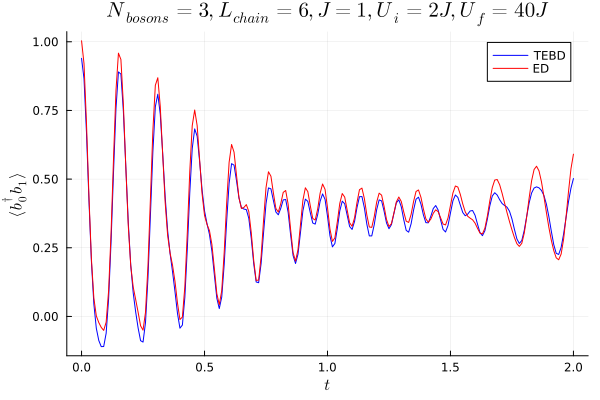

In [36]:
plot(Times_TEBD, Correlations_TEBD, label = "TEBD", color ="blue")
plot!(Times_ED, Correlations_ED, label = "ED", color ="red")

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!(L"N_{bosons} = 3, L_{chain} = 6, J = 1, U_{i} = 2J, U_{f} = 40J")

**Figure 1.**

In [37]:
#Quantum Quench of Figure 1.

N_Bosons = 9
L_Chain = 64 
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)

nsweeps = 10
maxdim = [10,20,100,200,300] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,N_Bosons+1); nsweeps, maxdim, cutoff) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-51.30350309867089  maxlinkdim=10 maxerr=2.26E-02 time=3.163
After sweep 2 energy=-72.95944265771458  maxlinkdim=20 maxerr=5.70E-05 time=7.361
After sweep 3 energy=-76.3579847004815  maxlinkdim=83 maxerr=1.00E-10 time=19.014
After sweep 4 energy=-78.09125121322893  maxlinkdim=95 maxerr=9.99E-11 time=26.626
After sweep 5 energy=-79.40219125774982  maxlinkdim=82 maxerr=9.98E-11 time=27.350
After sweep 6 energy=-80.51676087315963  maxlinkdim=73 maxerr=1.00E-10 time=25.097
After sweep 7 energy=-81.35554674770455  maxlinkdim=67 maxerr=1.00E-10 time=21.806
After sweep 8 energy=-82.14829936380333  maxlinkdim=89 maxerr=9.97E-11 time=22.088
After sweep 9 energy=-82.82477764727768  maxlinkdim=125 maxerr=9.95E-11 time=24.447
After sweep 10 energy=-83.36126298240595  maxlinkdim=85 maxerr=9.93E-11 time=19.388


(-83.36126298240595, MPS
[1] ((dim=10|id=62|"Link,l=1"), (dim=10|id=937|"Qudit,Site,n=1"))
[2] ((dim=24|id=329|"Link,l=2"), (dim=10|id=986|"Qudit,Site,n=2"), (dim=10|id=62|"Link,l=1"))
[3] ((dim=10|id=222|"Qudit,Site,n=3"), (dim=40|id=710|"Link,l=3"), (dim=24|id=329|"Link,l=2"))
[4] ((dim=10|id=690|"Qudit,Site,n=4"), (dim=46|id=936|"Link,l=4"), (dim=40|id=710|"Link,l=3"))
[5] ((dim=10|id=974|"Qudit,Site,n=5"), (dim=49|id=139|"Link,l=5"), (dim=46|id=936|"Link,l=4"))
[6] ((dim=10|id=234|"Qudit,Site,n=6"), (dim=48|id=263|"Link,l=6"), (dim=49|id=139|"Link,l=5"))
[7] ((dim=10|id=466|"Qudit,Site,n=7"), (dim=50|id=61|"Link,l=7"), (dim=48|id=263|"Link,l=6"))
[8] ((dim=10|id=318|"Qudit,Site,n=8"), (dim=56|id=427|"Link,l=8"), (dim=50|id=61|"Link,l=7"))
[9] ((dim=10|id=55|"Qudit,Site,n=9"), (dim=48|id=344|"Link,l=9"), (dim=56|id=427|"Link,l=8"))
[10] ((dim=10|id=589|"Qudit,Site,n=10"), (dim=48|id=78|"Link,l=10"), (dim=48|id=344|"Link,l=9"))
[11] ((dim=10|id=6|"Qudit,Site,n=11"), (dim=50|id=787|"L

In [42]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, N_Bosons, L_Chain, J, Uf, sites)

([0.9368388003832876, 0.8537406538040212, 0.6437183034021724, 0.3956678396114439, 0.1912286377187243, 0.06668740839755037, 0.010182473142787592, -0.013753678620596092, -0.03170232874003236, -0.04189154546864625  …  0.40179038747567647, 0.36911622574350655, 0.34723374087931597, 0.3444064489893733, 0.359323460978444, 0.38448599579360415, 0.40922292571328206, 0.42203167337828057, 0.4161390229067365, 0.3966233046312967], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

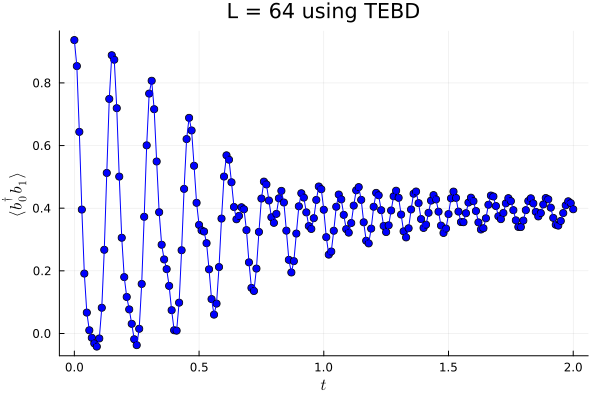

In [44]:
scatter(Times_TEBD, Correlations_TEBD, label = false, color = "blue")
plot!(Times_TEBD, Correlations_TEBD, label = false, color = "blue")

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("L = 64 using TEBD")